# Homework 2 (Yang Yue)

In [1]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d
from rasterio.warp import calculate_default_transform, reproject, Resampling

## Preparation of Data

In [2]:
#file locaiton
dir = "C:/Users/Yang Yue/Documents/GitHub/ACE_592_Clone/Homeworks/"

In [3]:
country = geopandas.read_file(dir+"us_states.json")
cdl_2016 = rasterio.open(dir+"CDL_2016_clip.tif")
cdl_2017 = rasterio.open(dir+"CDL_2017_clip.tif")

In [4]:
cdl_2016.transform*(0,0)
cdl_2017.transform*(0,0)

(337545.0, 2223945.0)

In [5]:
#continental US
country = country[~country['NAME'].isin(["Alaska","Hawaii","Puerto Rico"])]

In [6]:
#check crs
[country.crs == cdl_2016.crs,country.crs == cdl_2017.crs,cdl_2016.crs == cdl_2017.crs]

[False, False, True]

In [7]:
#reproject to the same crs
country_proj = country.to_crs(cdl_2016.crs)

## Question 1

In [8]:
#extract coordinates
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

IL_coords = getFeatures(country_proj[country_proj.NAME=="Illinois"])

img_out_2016,img_transform = mask(cdl_2016,IL_coords)
img_out_2017,img_transform = mask(cdl_2017,IL_coords)

In [9]:
#clip raster function
def clip_raster(raster,vector,filename):
    img_out,img_transform = mask(raster,getFeatures(vector))
    
    out_meta = raster.meta.copy()
    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = img_transform
    
    with rasterio.open(dir+filename,"w",**out_meta) as dest:
        dest.write(img_out)
        
    return rasterio.open(dir+filename)

In [10]:
IL_2016_c = clip_raster(cdl_2016,country_proj[country_proj.NAME=="Illinois"],"IL_2016_clip.tif")
IL_2017_c = clip_raster(cdl_2017,country_proj[country_proj.NAME=="Illinois"],"IL_2017_clip.tif")

(1900000.0, 2100000.0)

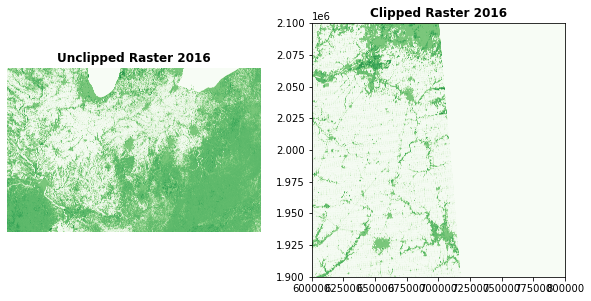

In [12]:
#2016 clipped and unclipped rasters
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

show(cdl_2016,ax=ax1,cmap='Greens',title="Unclipped Raster 2016")
ax1.axis('off')

show(IL_2016_c,ax=ax2,cmap='Greens',title="Clipped Raster 2016")
ax2.set_xlim(0.6e6,0.8e6)
ax2.set_ylim(1.9e6,2.1e6)
#ax2.axis('off')

(300000.0, 800000.0, 1554765.0, 2223945.0)

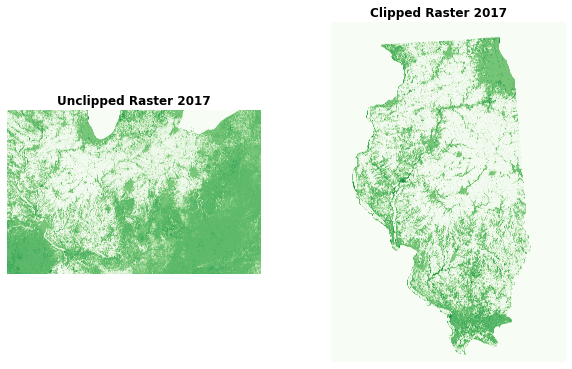

In [12]:
#2017 clipped and unclipped rasters
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

show(cdl_2017,ax=ax1,cmap='Greens',title="Unclipped Raster 2017")
ax1.axis('off')

show(IL_2017_c,ax=ax2,cmap='Greens',title="Clipped Raster 2017")
ax2.set_xlim(0.3e6,0.8e6)
ax2.axis('off')

## Question 2

In [13]:
IL_2016_array = IL_2016_c.read(1)
pixels_2016 = pd.Series(IL_2016_array.flatten())

IL_2017_array = IL_2017_c.read(1)
pixels_2017 = pd.Series(IL_2017_array.flatten())

pixels_2016 = pixels_2016[pixels_2016!=0]
pixels_2017 = pixels_2017[pixels_2017!=0]

In [14]:
#count pixels for each type of land use
pixel_counts_2016 = pixels_2016.value_counts()
pixel_counts_2017 = pixels_2017.value_counts()

In [15]:
#preliminary table that shows what need to be included in the incomplete table
df_land_2016 = pixel_counts_2016.reset_index()
df_land_2016.columns = ['Categorization Code','Pixel Counts 2016']

df_land_2017 = pixel_counts_2017.reset_index()
df_land_2017.columns = ['Categorization Code','Pixel Counts 2017']

In [16]:
#create an incomplete dictionary for land use
land_dict = {1:"Corn",5:"Soybeans",26:"Dbl Crop WinWht/Soybeans",111:"Open Water",121:"Developed/Open Space",
             122:"Developed/Low Intensity",123:"Developed/Med Intensity",141:"Deciduous Forest",176:"Grassland/Pasture",
             190:"Woody Wetlands"}

In [17]:
#add land use column
df_land_2016['Land Use 2016'] = df_land_2016['Categorization Code'].map(land_dict)

#land use in %
df_land_2016['Percentage 2016'] = df_land_2016['Pixel Counts 2016'].apply(lambda x: x/pixel_counts_2016.sum()*100)

df_land_2016.head(10)

,Categorization Code,Pixel Counts 2016,Land Use 2016,Percentage 2016
0,1,51601196,Corn,31.824279
1,5,43058354,Soybeans,26.555607
2,141,25593818,Deciduous Forest,15.784611
3,176,14392021,Grassland/Pasture,8.876067
4,122,7659122,Developed/Low Intensity,4.723651
5,121,7342593,Developed/Open Space,4.528436
6,111,2902471,Open Water,1.790056
7,123,2670760,Developed/Med Intensity,1.647152
8,190,1849448,Woody Wetlands,1.140620
9,26,1456404,Dbl Crop WinWht/Soybeans,0.898216


In [18]:
#add land use column
df_land_2017['Land Use 2017'] = df_land_2017['Categorization Code'].map(land_dict)

#land use in %
df_land_2017['Percentage 2017'] = df_land_2017['Pixel Counts 2017'].apply(lambda x: x/pixel_counts_2017.sum()*100)

df_land_2017.head(10)

,Categorization Code,Pixel Counts 2017,Land Use 2017,Percentage 2017
0,1,50384325,Corn,31.073792
1,5,44901528,Soybeans,27.692358
2,141,25540784,Deciduous Forest,15.751903
3,176,14179426,Grassland/Pasture,8.744953
4,122,7641962,Developed/Low Intensity,4.713068
5,121,7299778,Developed/Open Space,4.502031
6,111,2901269,Open Water,1.789315
7,123,2686450,Developed/Med Intensity,1.656829
8,190,1864898,Woody Wetlands,1.150148
9,26,1293584,Dbl Crop WinWht/Soybeans,0.797799


## Question 3

In [ ]:
#create corn layer 2016
corn_mask_2016 = IL_2016_array==1

IL_2016_array_1 = IL_2016_c.read(1)
IL_2016_array_1[~corn_mask_2016] = 0

img_out_2016_corn = IL_2016_array_1[np.newaxis,:,:]

out_meta_2016_corn = IL_2016_c.meta.copy()

out_meta_2016_corn['height'] = img_out_2016_corn.shape[1]
out_meta_2016_corn['width'] = img_out_2016_corn.shape[2]
out_meta_2016_corn['dtype'] = 'uint8'
out_meta_2016_corn['transform'] = IL_2016_c.transform

with rasterio.open(dir+"corn_layer_2016.tif","w",**out_meta_2016_corn) as dest:
    dest.write(img_out_2016_corn)

In [21]:
corn_2016 = rasterio.open(dir+"corn_layer_2016.tif","r+")
corn_2016.nodata = 0

corn_2016_array = corn_2016.read(1).astype(float)
corn_2016_binary = corn_2016_array!=0

In [22]:
#create soy layer 2016
soy_mask_2016 = IL_2016_array==5

IL_2016_array_2 = IL_2016_c.read(1)
IL_2016_array_2[~soy_mask_2016] = 0

img_out_2016_soy = IL_2016_array_2[np.newaxis,:,:]

out_meta_2016_soy = IL_2016_c.meta.copy()

out_meta_2016_soy['height'] = img_out_2016_soy.shape[1]
out_meta_2016_soy['width'] = img_out_2016_soy.shape[2]
out_meta_2016_soy['dtype'] = 'uint8'
out_meta_2016_soy['transform'] = IL_2016_c.transform

with rasterio.open(dir+"soy_layer_2016.tif","w",**out_meta_2016_soy) as dest:
    dest.write(img_out_2016_soy)

In [23]:
soy_2016 = rasterio.open(dir+"soy_layer_2016.tif","r+")
soy_2016.nodata = 0

soy_2016_array = soy_2016.read(1).astype(float)
soy_2016_binary = soy_2016_array!=0

(0.0, 15000.0, 22305.5, -0.5)

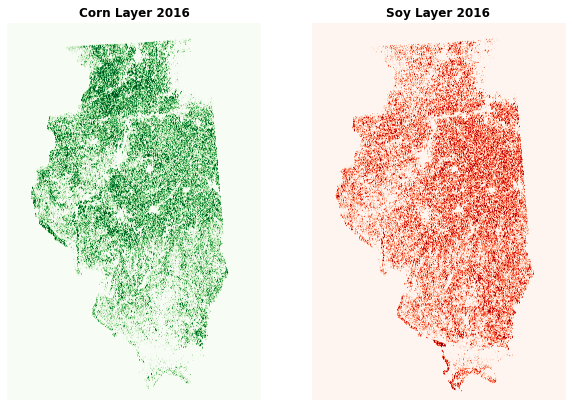

In [37]:
#plot corn and soy raster for 2016
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

rasterio.plot.show(corn_2016_binary,ax=ax1,cmap='Greens',title='Corn Layer 2016')
ax1.set_xlim(0,15000)
ax1.axis('off')

rasterio.plot.show(soy_2016_binary,ax=ax2,cmap='Reds',title='Soy Layer 2016')
ax2.set_xlim(0,15000)
ax2.axis('off')

In [38]:
#create corn layer 2017
corn_mask_2017 = IL_2017_array==1

IL_2017_array_1 = IL_2017_c.read(1)
IL_2017_array_1[~corn_mask_2017] = 0

img_out_2017_corn = IL_2017_array_1[np.newaxis,:,:]

out_meta_2017_corn = IL_2017_c.meta.copy()

out_meta_2017_corn['height'] = img_out_2017_corn.shape[1]
out_meta_2017_corn['width'] = img_out_2017_corn.shape[2]
out_meta_2017_corn['dtype'] = 'uint8'
out_meta_2017_corn['transform'] = IL_2017_c.transform

with rasterio.open(dir+"corn_layer_2017.tif","w",**out_meta_2017_corn) as dest:
    dest.write(img_out_2017_corn)

In [40]:
corn_2017 = rasterio.open(dir+"corn_layer_2017.tif","r+")
corn_2017.nodata = 0

corn_2017_array = corn_2017.read(1).astype(float)
corn_2017_binary = corn_2017_array!=0

In [41]:
#create soy layer 2017
soy_mask_2017 = IL_2017_array==5

IL_2017_array_2 = IL_2017_c.read(1)
IL_2017_array_2[~soy_mask_2017] = 0

img_out_2017_soy = IL_2017_array_2[np.newaxis,:,:]

out_meta_2017_soy = IL_2017_c.meta.copy()

out_meta_2017_soy['height'] = img_out_2017_soy.shape[1]
out_meta_2017_soy['width'] = img_out_2017_soy.shape[2]
out_meta_2017_soy['dtype'] = 'uint8'
out_meta_2017_soy['transform'] = IL_2017_c.transform

with rasterio.open(dir+"soy_layer_2017.tif","w",**out_meta_2017_soy) as dest:
    dest.write(img_out_2017_soy)

In [44]:
soy_2017 = rasterio.open(dir+"soy_layer_2017.tif","r+")
soy_2017.nodata = 0

soy_2017_array = soy_2017.read(1).astype(float)
soy_2017_binary = soy_2017_array!=0

(0.0, 15000.0, 22305.5, -0.5)

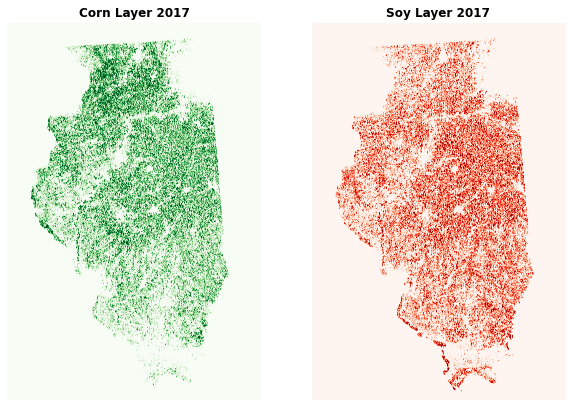

In [46]:
#plot corn and soy raster for 2017
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

rasterio.plot.show(corn_2017_binary,ax=ax1,cmap='Greens',title='Corn Layer 2017')
ax1.set_xlim(0,15000)
ax1.axis('off')

rasterio.plot.show(soy_2017_binary,ax=ax2,cmap='Reds',title='Soy Layer 2017')
ax2.set_xlim(0,15000)
ax2.axis('off')

## Question 4 & 5

In [50]:
#create new rasters that categorize land use as corn, soybean, and others for 2016 and 2017
def raster_cso(raster,filename):
    x = raster.read(1)
    img_out = np.zeros(x.shape)
    
    corn_mask = x==1
    soy_mask = x==5
    
    img_out[corn_mask] = 1
    img_out[soy_mask] = 2
    
    img_out = img_out[np.newaxis,:,:].astype(np.uint8)
    
    out_meta = raster.meta.copy()
    
    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = raster.transform
    out_meta['dtype'] = 'uint8'
    
    with rasterio.open(dir+filename,"w",**out_meta) as dest:
        dest.write(img_out)
     
    return rasterio.open(dir+filename)

In [51]:
cso_2016 = raster_cso(IL_2016_c,"cso_2016.tif")
cso_2017 = raster_cso(IL_2017_c,"cso_2017.tif")

In [52]:
#create Illinois projection
IL = country[country['NAME'].isin(["Illinois"])]

IL_proj = IL.to_crs(cdl_2016.crs)

In [53]:
#preparation for land use graph according to the new categorization
labels = {0:"Others",1:"Corn",2:"Soybean"}

cmap = matplotlib.colors.ListedColormap(['White','C3','C0'])

patches = [mpatches.Patch(color=cmap(i),label=labels[i]) for i in labels.keys()]

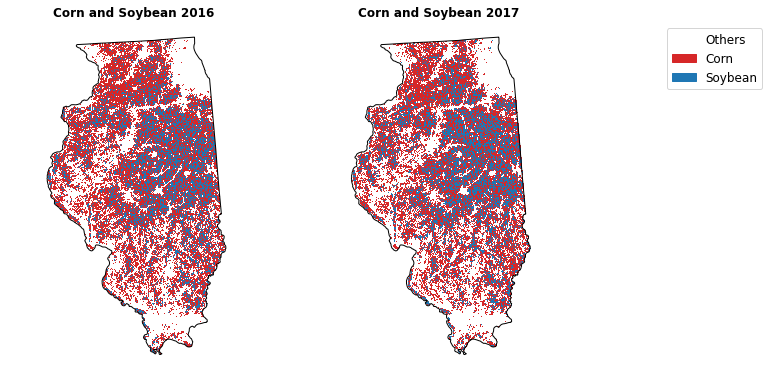

In [54]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

rasterio.plot.show(cso_2016,cmap=cmap,ax=ax1,title='Corn and Soybean 2016')
IL_proj.plot(ax=ax1,facecolor='none',edgecolor='black')
ax1.set_xlim(0.3e6,0.8e6)
ax1.axis('off')

rasterio.plot.show(cso_2017,cmap=cmap,ax=ax2,title='Corn and Soybean 2017')
IL_proj.plot(ax=ax2,facecolor='none',edgecolor='black')
ax2.set_xlim(0.3e6,0.8e6)
ax2.axis('off')

plt.legend(handles=patches,fontsize=12,bbox_to_anchor=(1.8,1))

In [55]:
#construct a function that captures rotation 
def visualize_rotate(y1,y2,filename):
    a1 = y1.read(1)
    a2 = y2.read(1)
    
    c_to_c = (a1==1)&(a2==1)
    s_to_s = (a1==2)&(a2==2)
    c_to_s = (a1==1)&(a2==2)
    s_to_c = (a1==2)&(a2==1)
    
    a = np.zeros(a1.shape)
    
    a[c_to_c] = 1
    a[s_to_s] = 2
    a[c_to_s] = 3
    a[s_to_c] = 4
    
    img_out = a[np.newaxis,:,:].astype(np.uint8)
    
    out_meta = y1.meta.copy()
    
    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = y1.transform
    out_meta['dtype'] = 'uint8'
    
    with rasterio.open(dir+filename,"w",**out_meta) as dest:
        dest.write(img_out)
        
    return rasterio.open(dir+filename)

In [56]:
rotation_labels = {0:"Others",
                   1:"Corn to Corn",
                   2:"Soybean to Soybean", 
                   3:"Corn to Soybean",
                   4:"Soybean to Corn"}

In [57]:
#new raster that captures corn-soybean rotation
rotation_2016_2017 = visualize_rotate(cso_2016,cso_2017,"cso_2016_2017.tif")

In [58]:
#degree of rotation in percentage from 2016 to 2017
rotation_counts = pd.Series(rotation_2016_2017.read(1).flatten()).value_counts().iloc[1:]
rotation_counts.index = pd.Series(rotation_counts.index).replace(rotation_labels)
rotation_degree = rotation_counts/rotation_counts.sum()*100

rotation_degree

Corn to Soybean       40.652442
Soybean to Corn       38.187609
Corn to Corn          14.326163
Soybean to Soybean     6.833786
dtype: float64

## Question 6

### My Submission

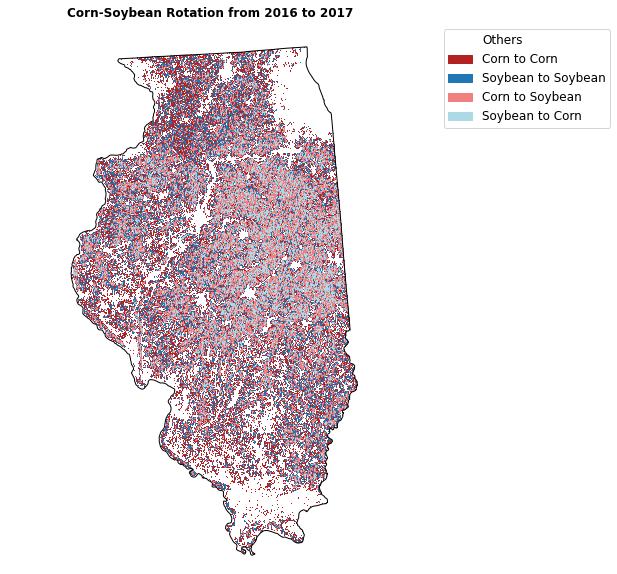

In [59]:
#visualize the raster file
fix,ax = plt.subplots(figsize=(10,10))

cmap = matplotlib.colors.ListedColormap(['White','firebrick','C0','lightcoral','lightblue'])

patches = [mpatches.Patch(color=cmap(i),label=rotation_labels[i]) for i in rotation_labels.keys()]

#rotation 2016-2017
rasterio.plot.show(rotation_2016_2017,cmap=cmap,ax=ax,title='Corn-Soybean Rotation from 2016 to 2017')
IL_proj.plot(ax=ax,facecolor='none',edgecolor='black')
ax.set_xlim(0.3e6,0.8e6)
ax.axis('off')

plt.legend(handles=patches,fontsize=12,bbox_to_anchor=(1.5,1))

## Question 7

- What data sources you would need in addition to the raster you just created?

I would need to have the annual crop yield data for 2017 at minimum to be able to comment on the issue. 

- How you would manipulate the data?

I would map each pixel to a crop yield measure derived from the above mentioned data source. 

- What statistics you would calculate or model you would run on this data?

I would create dummy variables for each pixel reflecting its rotation status. Then, I would calculate the correlation between rotation status and crop yield in 2017. Also, I would calculate the county-level average corn/soybean yield for pixels that did not experience rotation.

- How you might present your findings?

I would highlight the pixels that experienced rotation and had higher-than-county-average crop yield for either corn or soybean. I would also emphasize the percentage of highlighted pixels in all pixels that exprienced rotation within each county. 

## Question 8

- One key issue is that it's hard to construct perfect counterfactual. Ideally, we need to compare the crop yield of a pixel in all 4 cases: corn to corn vs. soybean to corn, soybean to soybean vs. corn to soybean. Clearly, obtaining such comparison for the same pixel over the same timespan is not possible. 

- It is possible that different farms employed different farming techniques (seed variations, use of pesticide etc). These differences could impact crop yield in addition to rotation status. Although doing the analysis by county helps a little bit since the differences is unlikely to be significant for pixels adjacent to each other, it is still hard to completely eliminate the noise. 

- As apparent from the result, only 20% of the pixels did not exprience rotation. The small sample size may affect the accuracy of the calculated benchmark crop yield for each county. 